# 股吧情绪分析

目标地址

http://guba.eastmoney.com/list,of161725.html


代理池

https://github.com/jhao104/proxy_pool

## 一、导入程序

In [3]:
# import csv
import time
import random
import requests
import traceback
from time import sleep
from fake_useragent import UserAgent
from lxml import etree
import pandas as pd
import re
import math


## 二、程序设计

### 1、数据源获取

> 无限请求，直到请求到数据

In [4]:
# page = 1  #设置爬取的页数
# fundcode = 161725  #可替换任意基金代码
# sleep(random.uniform(1, 2))  #随机出现1-2之间的数，包含小数
# headers = {"User-Agent": UserAgent(verify_ssl=False).random}
# url = f'http://guba.eastmoney.com/list,of{fundcode}_{page}.html'
# response = requests.get(url, headers=headers, timeout=10)
# print(response)


def get_fund_data(fundcode='161725', page=1, proxies=None):
    try:
        # page = 1  #设置爬取的页数
        # fundcode = 161725  #可替换任意基金代码
        sleep(random.uniform(1, 5))  #随机出现1-2之间的数，包含小数
        headers = {"User-Agent": UserAgent().random}
        url = f'http://guba.eastmoney.com/list,of{fundcode}_{page}.html'
        print('开始请求')
        print(url)
        response = requests.get(url, headers=headers, timeout=10, proxies=proxies)
        # print(response)
        return response.text
    except requests.exceptions.ConnectionError:
        t = random.uniform(1, 5)
        print(f'ConnectionError -- please wait {t} seconds')
        time.sleep(random.uniform(1, 5))
        return get_fund_data(fundcode, page, proxies)
    except requests.exceptions.ChunkedEncodingError:
        t = random.uniform(1, 5)
        print(f'ChunkedEncodingError -- please wait {t} seconds')
        time.sleep(t)
        return get_fund_data(fundcode, page, proxies)
    except:
        t = random.uniform(1, 5)
        print(
            f'Unfortunitely -- An Unknow Error Happened, Please wait {t} seconds'
        )
        time.sleep(t)
        return get_fund_data(fundcode, page, proxies)

response = get_fund_data()

开始请求
http://guba.eastmoney.com/list,of161725_1.html


### 2、解析数据

In [5]:
# 获取总页数
def parse_total(html):
    parse = etree.HTML(html)
    # print(etree.tostring(parse))
    div = parse.xpath('//*[@id="articlelistnew"]/div')[-2]
    total = div.text
    # 总共篇数
    total = re.findall(r'(\d+)', total)[0]
    # 总页数, 总篇数/单页条数，再向上取整
    total = math.ceil((int(total) / 80))
    return total

total = parse_total(response)
# etree.tostring(total)
total


9530

In [6]:
# 获取数据源
def parse_fund(html):
    parse = etree.HTML(html)  # 解析网页
    items = parse.xpath('//*[@id="articlelistnew"]/div')[1:-2]
    data = []
    columns = ['阅读', '评论', '标题', '作者', '时间']
    for item in items:
        _arr = [
            ''.join(item.xpath('./span[1]/text()')).strip(),
            ''.join(item.xpath('./span[2]/text()')).strip(),
            ''.join(item.xpath('./span[3]/a/text()')).strip(),
            ''.join(item.xpath('./span[4]/a/font/text()')).strip(),
            ''.join(item.xpath('./span[5]/text()')).strip()
        ]
        # item = {
        #     '阅读': ''.join(item.xpath('./span[1]/text()')).strip(),
        #     '评论': ''.join(item.xpath('./span[2]/text()')).strip(),
        #     '标题': ''.join(item.xpath('./span[3]/a/text()')).strip(),
        #     '作者': ''.join(item.xpath('./span[4]/a/font/text()')).strip(),
        #     '时间': ''.join(item.xpath('./span[5]/text()')).strip()
        # }
        data.append(_arr)
        # print(item)
    # print(arr)
    df = pd.DataFrame(data=data,columns=columns)
    return df
df = parse_fund(response)
df

,阅读,评论,标题,作者,时间
0,1775,12,有奖聊 | 那些年我们一起用过的电池,嘉实基金,09-11 16:32
1,4356,75,【3000元京东卡】全能成长猎手钟帅重磅新基来袭！记得,华夏基金,09-11 16:06
2,1591,5,【有机会瓜分66666积分】这个中秋，与德邦共赴“飞花,德邦基金,09-11 11:04
3,14375,21,【有机会瓜分3000壕礼】神仙智能家电大种草！,富国基金,09-11 09:01
4,26321,78,A股出现神奇一幕，医药越跌越买基金越亏越多，医药还,龙行天下虎呀,09-11 15:54
...,...,...,...,...,...
79,3853,15,0905猴哥午评：指数走低后翻红，资金回流能源板块！,小猴论市,09-10 20:26
80,11485,44,医疗利好来袭，今天怎么还创新低？真的没救了吗？,西瓜看盘,09-10 20:26
81,13659,143,天天乐观明起飞，日日悲伤全是泪。周周下跌一团糟，月,赵吹吹,09-10 20:26
82,113810,413,超级风暴！暴跌20%，美股40年牛市终结，史诗级的崩盘,小猴论市,09-10 20:26


### 3、保存到csv

In [6]:
df.to_csv('股吧情绪分析.csv', index=False)

## 三、设计主函数

### 1、添加代理池

参考：https://github.com/jhao104/proxy_pool

In [7]:

def get_proxy():
    return requests.get("http://demo.spiderpy.cn/get/").json()


def delete_proxy(proxy):
    requests.get(f"http://demo.spiderpy.cn/delete/?proxy={proxy}")

### 2、设计分页异常函数

In [7]:
proxyObj = get_proxy()
proxy = proxyObj.get("proxy")
region = proxyObj.get('region')
proxies = { "http": f"http://{proxy}" }
# proxies = None
print(f'代理:{proxy}, 位置:{region}')

def main(fundcode='161725', page = 1, total=None):
    # try:
    html = get_fund_data(fundcode, page, proxies)
    df = pd.DataFrame()
    if total is None:
        total = parse_total(html)
    print(f'第{page}页/总页数: {total}')
    for page_i in range(page, total):
        # 一定要加随机时间，防止被反爬
        # time.sleep(random.uniform(1, 5))
        if page_i > 0 and page > 1:
            html = get_fund_data(fundcode, page_i, proxies)
            df = parse_fund(html)
        else:
            df = parse_fund(html)
        # 数据为空的情况
        if df.empty is True:
            # 数据为空，重新执行
            main(fundcode, page_i, total)
        # print(f'获取第{page_i}页数据内容')
        # print(df)
        df.to_csv('./股吧情绪分析.csv', mode='a', index=False, header=False)
        print(f'第{page_i}页数据内容, 保存成功!')
    # except Exception as e:
    #     print(e)
    #     print(f'第{page}页有异常，正在重新请求..')
    # main(fundcode, page, total)
main()

代理:183.250.163.175:9091, 位置:中国 福建 厦门 移动
开始请求
http://guba.eastmoney.com/list,of161725_1.html
第1页/总页数: 9530
开始请求
http://guba.eastmoney.com/list,of161725_1.html
获取第1页数据内容
第1页数据内容保存成功!
开始请求
http://guba.eastmoney.com/list,of161725_2.html
获取第2页数据内容
第2页数据内容保存成功!
开始请求
http://guba.eastmoney.com/list,of161725_3.html
获取第3页数据内容
第3页数据内容保存成功!
开始请求
http://guba.eastmoney.com/list,of161725_4.html
获取第4页数据内容
第4页数据内容保存成功!
开始请求
http://guba.eastmoney.com/list,of161725_5.html
获取第5页数据内容
第5页数据内容保存成功!
开始请求
http://guba.eastmoney.com/list,of161725_6.html
获取第6页数据内容
第6页数据内容保存成功!
开始请求
http://guba.eastmoney.com/list,of161725_7.html
获取第7页数据内容
第7页数据内容保存成功!
开始请求
http://guba.eastmoney.com/list,of161725_8.html
获取第8页数据内容
第8页数据内容保存成功!
开始请求
http://guba.eastmoney.com/list,of161725_9.html
获取第9页数据内容
第9页数据内容保存成功!
开始请求
http://guba.eastmoney.com/list,of161725_10.html
获取第10页数据内容
第10页数据内容保存成功!
开始请求
http://guba.eastmoney.com/list,of161725_11.html
获取第11页数据内容
第11页数据内容保存成功!
开始请求
http://guba.eastmoney.com/list,of161725_12.html
获取第12页数据内容

## 四、可视化

### 1、导入数据

In [25]:
df = pd.read_csv("股吧情绪分析.csv",
                 names=['阅读', '评论', '标题', '作者', '时间'])
                
df
# df['时间'] = df['时间'].apply(lambda x: x+1)
# df['阅读'] = df['阅读'].str.replace('万','').astype('float')
# df['时间'] = pd.to_datetime(df['时间'],errors='ignore') 

,阅读,评论,标题,作者,时间
0,1767,12,有奖聊 | 那些年我们一起用过的电池,嘉实基金,09-11 16:32
1,4353,75,【3000元京东卡】全能成长猎手钟帅重磅新基来袭！记得,华夏基金,09-11 16:06
2,1587,5,【有机会瓜分66666积分】这个中秋，与德邦共赴“飞花,德邦基金,09-11 11:04
3,14371,21,【有机会瓜分3000壕礼】神仙智能家电大种草！,富国基金,09-11 09:01
4,26227,78,A股出现神奇一幕，医药越跌越买基金越亏越多，医药还,龙行天下虎呀,09-11 15:54
...,...,...,...,...,...
8239,945,0,复盘丨下午突然缩量，但投资资金在加大，后期这样看！,铁臂阿童木2来了,08-08 15:31
8240,5023,4,周日评丨下周将迎来雨后彩虹，具体行情听我说说！,铁臂阿童木2来了,08-08 15:26
8241,1702,1,煤炭大反攻！新能源分化反弹，白酒、医疗微跌，有持仓,小小说理财,08-08 15:22
8242,2299,4,盘中分析：小涨小跌？今天A股涨跌或许早已暗中注定！,小高理财吖,08-08 15:15


### 2、数据清洗

In [26]:
#重复和缺失数据
df = df.drop_duplicates()
df = df.dropna()

# 临时更改，测试使用
# df['时间'] = df['时间'].apply(lambda x: x.replace('09-10', '2022-09-09'))
df['时间'] = df['时间'].apply(lambda x: f'2022-{x}')
df['时间'] = pd.to_datetime(df['时间'])
# 评论时间有可能是周末，所以要限制
someday = pd.to_datetime('2022-09-09 15:00')
df = df[df['时间'] <= someday]

#数据类型转换
# df['阅读'] = df['阅读'].str.replace('万','').astype('float')
df['阅读'] = df['阅读'].astype('float')
# df['时间'] = pd.to_datetime(df['时间'],errors='ignore')

#机械压缩去重
def yasuo(st):
    for i in range(1,int(len(st)/2)+1):
        for j in range(len(st)):
            if st[j:j+i] == st[j+i:j+2*i]:
                k = j + i
                while st[k:k+i] == st[k+i:k+2*i] and k<len(st):
                    k = k + i
                st = st[:j] + st[k:]
    return st
yasuo(st="J哥J哥J哥J哥J哥")
df["标题"] = df["标题"].apply(yasuo)

#过滤表情
df['标题'] = df['标题'].str.extract(r"([\u4e00-\u9fa5]+)")
df = df.dropna()  #纯表情直接删除

#过滤短句
# df = df[df["标题"].apply(len)>=3]
df = df.dropna()
df

,阅读,评论,标题,作者,时间
267,86.0,0,垃圾,基民l9G0263601,2022-09-09 15:00:00
268,95.0,0,涨的不够塞牙缝,理财拿捏最准小滑头,2022-09-09 14:59:00
269,130.0,2,涨一个多点属实没有什么参考意义,玩基笑笑生,2022-09-09 14:58:00
270,82.0,0,跳水,基民do76788916,2022-09-09 14:57:00
271,486.0,6,电子,发财一条路1,2022-09-09 14:56:00
...,...,...,...,...,...
8239,945.0,0,复盘丨下午突然缩量,铁臂阿童木2来了,2022-08-08 15:31:00
8240,5023.0,4,周日评丨下周将迎来雨后彩虹,铁臂阿童木2来了,2022-08-08 15:26:00
8241,1702.0,1,煤炭大反攻,小小说理财,2022-08-08 15:22:00
8242,2299.0,4,盘中分析,小高理财吖,2022-08-08 15:15:00


### 3、制作词云

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/w6/9k4dzqlj617f06dfby_vk1pr0000gn/T/jieba.cache
Loading model cost 1.237 seconds.
Prefix dict has been built successfully.


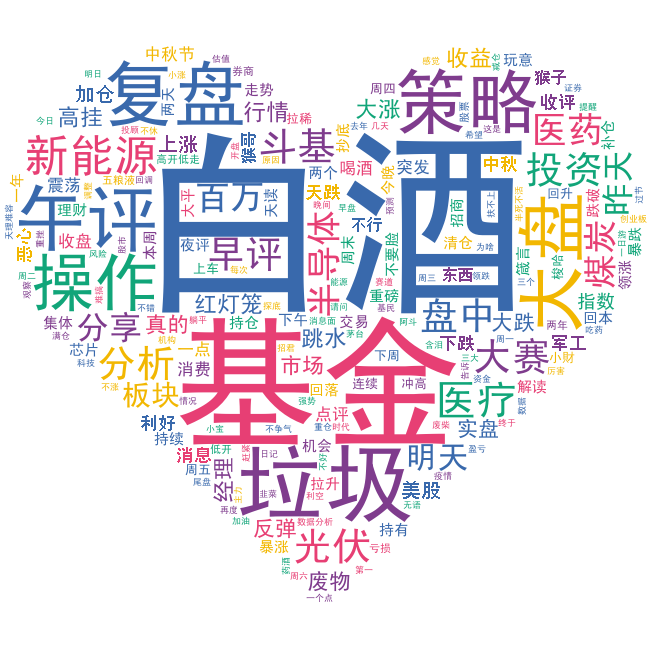

In [6]:
import jieba
import stylecloud
from IPython.display import Image


def get_cut_words(content_series):
    # 读入停用词表
    stop_words = []

    with open("./停用词.txt", 'r', encoding='UTF-8') as f:
        lines = f.readlines()
        for line in lines:
            stop_words.append(line.strip())

    # 添加关键词
    my_words = []
    for i in my_words:
        jieba.add_word(i)

        # 自定义停用词
    my_stop_words = []
    stop_words.extend(my_stop_words)

    # 分词
    word_num = jieba.lcut(content_series.str.cat(sep='。'), cut_all=False)
    # print(word_num)
    # 条件筛选
    word_num_selected = [
        i for i in word_num if i not in stop_words and len(i) >= 2
    ]
    # print(word_num_selected)
    return word_num_selected
# jieba.cut(content_)
# 绘制词云图
text1 = get_cut_words(content_series=df['标题'])
stylecloud.gen_stylecloud(text=' '.join(text1), max_words=200,
                          collocations=False,
                          font_path='../SimHei.ttf',
                          icon_name='fas fa-heart',
                          size=653,
                          #palette='matplotlib.Inferno_9',
                          output_name='./基金.png')
Image(filename='./基金.png')


## 五、情绪分析

In [27]:
import paddlehub as hub

# 用在线模型
# senta = hub.Module(name="senta_bilstm")
# 在线模型下载失败，就用本地模型
senta = hub.Module(directory="./senta_bilstm")
texts = df['标题'].tolist()
input_data = {'text': texts}
res = senta.sentiment_classify(data=input_data)
df['投资者情绪'] = [x['positive_probs'] for x in res]
df

[2022-09-12 09:17:28,623] [ WARNING] - The _initialize method in HubModule will soon be deprecated, you can use the __init__() to handle the initialization of the object
[2022-09-12 09:17:52,098] [ WARNING] - The _initialize method in HubModule will soon be deprecated, you can use the __init__() to handle the initialization of the object


,阅读,评论,标题,作者,时间,投资者情绪
267,86.0,0,垃圾,基民l9G0263601,2022-09-09 15:00:00,0.0163
268,95.0,0,涨的不够塞牙缝,理财拿捏最准小滑头,2022-09-09 14:59:00,0.1681
269,130.0,2,涨一个多点属实没有什么参考意义,玩基笑笑生,2022-09-09 14:58:00,0.0833
270,82.0,0,跳水,基民do76788916,2022-09-09 14:57:00,0.4778
271,486.0,6,电子,发财一条路1,2022-09-09 14:56:00,0.6463
...,...,...,...,...,...,...
8239,945.0,0,复盘丨下午突然缩量,铁臂阿童木2来了,2022-08-08 15:31:00,0.3273
8240,5023.0,4,周日评丨下周将迎来雨后彩虹,铁臂阿童木2来了,2022-08-08 15:26:00,0.9473
8241,1702.0,1,煤炭大反攻,小小说理财,2022-08-08 15:22:00,0.0577
8242,2299.0,4,盘中分析,小高理财吖,2022-08-08 15:15:00,0.4794


### 对数据进行重采样

In [34]:
#重采样至15分钟
# df.dtypes

data = df
# data['时间'] = pd.to_datetime(data['时间'])

# data.index = data['时间']
data = data.set_index('时间', drop=True)
data = data.resample('15min').mean().reset_index()
# print(data)
data

,时间,阅读,评论,投资者情绪
0,2022-08-08 15:00:00,85.000000,0.000000,0.006600
1,2022-08-08 15:15:00,3008.000000,3.000000,0.494800
2,2022-08-08 15:30:00,1726.400000,3.200000,0.707900
3,2022-08-08 15:45:00,2834.000000,5.666667,0.804967
4,2022-08-08 16:00:00,NaN,NaN,NaN
...,...,...,...,...
3068,2022-09-09 14:00:00,369.200000,0.000000,0.343220
3069,2022-09-09 14:15:00,758.000000,0.250000,0.427825
3070,2022-09-09 14:30:00,449.000000,1.133333,0.439693
3071,2022-09-09 14:45:00,816.333333,3.555556,0.345633


## 六、舆论与股价关联

<AxesSubplot:xlabel='时间'>

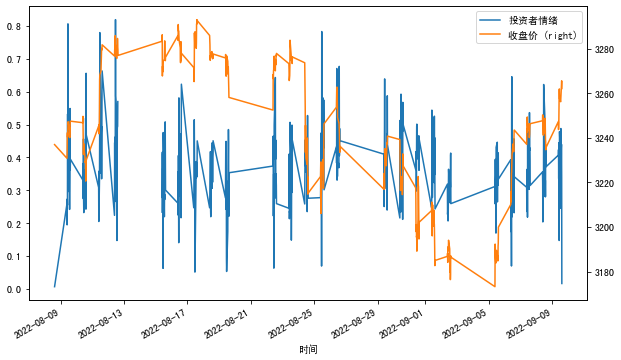

In [35]:
import akshare as ak
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus']=False#用来正常显示负号

sz_index = ak.stock_zh_a_minute(symbol='sh000001', period='15', adjust="qfq")
sz_index['日期'] = pd.to_datetime(sz_index['day'])
sz_index['收盘价'] = sz_index['close'].astype('float')
# print(sz_index)
data2 = data.merge(sz_index, left_on='时间', right_on='日期', how='inner')
# print(data2)
# data2.index = data2['时间']
data2.plot.line(x='时间',y=['投资者情绪', '收盘价'], secondary_y=['收盘价'],figsize=(10,6))
# matplotlib.use('Qt5Agg')
# data2.index = data2['时间']
# data2[['投资者情绪', '收盘价']].plot(secondary_y=['close'], figsize=(10,6))
# plt.show()

### 散点图

<AxesSubplot:xlabel='收盘价', ylabel='投资者情绪'>

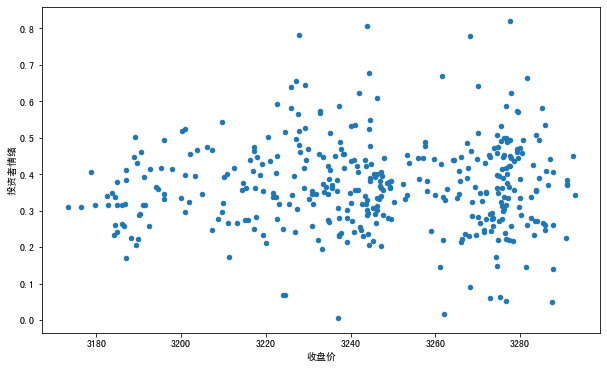

In [37]:
data2.plot(kind='scatter', x='收盘价', y='投资者情绪', figsize=(10,6))